<a href="https://colab.research.google.com/github/mridul-sahu/transformers-from-scratch/blob/main/Transformers_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# From Zero to ¡Hola!: Building a Sassy Spanish Translator with Flax, JAX, and a Dash of Humor

¡Hola, intrepid coder! Welcome to an epic quest where we'll transform you from a mere mortal into a bona fide **Neural Machine Translation Maestro**. Or, at the very least, someone who can make a computer utter "hola" after seeing "hello." Close enough, right?

Our mission, should you choose to accept it (and you kinda already have by being here), is to build an English-to-Spanish translator. But not just *any* translator. We're going to build it using the shiniest, most modern toolkit in the Wild West of AI:

* **JAX:** For NumPy-like operations that run on GPUs/TPUs faster than a roadrunner escaping a coyote.
* **Flax (NNX):** Our "LEGO set for neural nets" – making complex model building feel intuitive and, dare I say, fun! We're using the cutting-edge NNX (Next Generation) API.
* **Grain:** The Ferrari of data pipelines. Say goodbye to data bottlenecks and hello to feeding our model at lightning speed.
* **Optax:** Our wise sensei for optimization, guiding our model down the path of enlightenment (and lower loss values).
* **Orbax:** The diligent lab assistant, ensuring we don't lose our precious model brains to the void (it's for checkpointing, folks).

Why this fancy stack? Because we're not just building a model; we're crafting an *experience*. And because these tools are what the cool kids (and serious researchers/engineers) use to push the boundaries of AI. So, grab your favorite beverage, put on your coding hat (the one with the propeller, obviously), and let's turn some Python code into (somewhat) coherent Spanish!

## Part 1: Equipping Our Digital Selves - The Setup Ritual

Before we can even dream of our model uttering its first "hola," we need to gather our digital tools. Think of this as the pre-heist montage in a movie, where the team assembles their quirky gadgets. Our gadgets are Python libraries!

Here's our shopping list:

* `flax`: The star of our show for building neural network architectures with JAX. We'll be using its sleek NNX (Next Generation) API.
* `jax` & `jaxlib`: The dynamic duo that enables super-fast numerical computation on accelerators (GPUs/TPUs). `jax` is the frontend, `jaxlib` is the backend muscle.
* `optax`: For all our optimization needs – think fancy algorithms to help our model learn efficiently. It's like a personal trainer for your neural net.
* `orbax-checkpoint`: Our insurance policy. It saves our model's progress so we don't have to cry if the power goes out mid-training.
* `grain`: The high-performance data loading library from Google. It'll make sure our model never goes hungry for data.
* `sentencepiece`: The magic word-mincer! It tokenizes our text into bite-sized pieces our model can digest. We'll be using a pre-trained model here.
* `metrax`: For when we need to actually score our translations. It helps us calculate the BLEU score, the de facto (though slightly flawed) standard for translation quality.
* `tqdm`: Because watching progress bars is the true meaning of life for any programmer training a model.
* `numpy`: The granddaddy of numerical Python, still essential for various data manipulations.

Let's get 'em!

In [129]:
!pip install --upgrade "flax" "jax" "optax" "orbax-checkpoint" "grain" "sentencepiece" "google-metrax" "tqdm" "clu"

In [130]:
# Let the ancient Pythonic spirits be summoned!
# (Or, you know, just import the libraries we need.)

import flax
from flax import nnx # The shiny new Next Generation Flax API!

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap

import numpy as np
import optax
import orbax.checkpoint as ocp

from grain import python as pygrain

import sentencepiece as spm
from tqdm.notebook import tqdm # For those lovely progress bars in notebooks
import metrax

# Standard Python libraries
import os
import pathlib
import shutil # For cleaning up directories if needed
import urllib.request
import zipfile
from typing import List, Tuple, Dict, Any, Iterable, Callable, Optional

# For reproducibility (optional, but good practice!)
print(f"JAX version: {jax.__version__}")
print(f"Flax version: {flax.__version__}")
print(f"Optax version: {optax.__version__}")
print(f"Orbax version: {ocp.__version__}")
print(f"SentencePiece version: {spm.__version__}")
print(f"NumPy version: {np.__version__}")

JAX version: 0.6.0
Flax version: 0.10.6
Optax version: 0.2.4
Orbax version: 0.11.13
SentencePiece version: 0.2.0
NumPy version: 2.0.2


## Part 2: Fueling the Machine - Data & Our Trusty Tokenizer

Alright, our coding environment is sparkling clean and bristling with new libraries. Now, for the main course: **data**. Our Transformer, much like a very sophisticated Tamagotchi, gets hungry. And it doesn't eat just *any* data. It has a refined palate for tokenized sentences!

**The Feast: English-Spanish Sentences**

We'll be using a delightful dataset of English sentences and their Spanish translations, lovingly provided by `http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip`. It's a collection of pairs like:

* "Hello."  "Hola."
* "I love you." "Te amo."
* "My hovercraft is full of eels."  "Mi aerodeslizador está lleno de anguilas." (Okay, maybe not that last one, but you get the idea!)

**The Magical Word-Mincer: SentencePiece Tokenizer**

Raw text is like trying to feed our model a whole watermelon – it just won't work. We need to break it down into manageable, bite-sized pieces called "tokens." For this, we'll use our trusty **SentencePiece tokenizer**, specifically the `eng_spa_spm.model` that we (or someone very kind) trained in a previous adventure (or we'll just download it because we're practical like that). This tokenizer knows the common sub-word units for both English and Spanish in our dataset.

Let's go fetch these crucial ingredients!

In [131]:
# Let's set up some paths for our culinary ingredients (data and tokenizer model)
data_dir = pathlib.Path("/tmp/data")
data_dir.mkdir(parents=True, exist_ok=True)

# Dataset URL and paths
dataset_url = "http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
zip_file_path = data_dir / "spa-eng.zip"
extracted_data_path = data_dir / "spa-eng"
text_file_path = extracted_data_path / "spa.txt" # This contains English-Spanish pairs

# Tokenizer model URL and path
# IMPORTANT: This assumes the tokenizer model is available at this GitHub raw link.
# If you have it locally from the previous tutorial, you can adjust the path.
tokenizer_model_url = "https://raw.githubusercontent.com/mridul-sahu/tokenizing-with-sentencepiece/main/eng_spa_spm.model"
tokenizer_model_name = "eng_spa_spm.model"
tokenizer_model_path = data_dir / tokenizer_model_name

# --- Download and Extract Dataset ---
if not text_file_path.exists():
    if not zip_file_path.exists():
        print(f"Downloading dataset from {dataset_url}...")
        urllib.request.urlretrieve(dataset_url, zip_file_path)
        print(f"Dataset downloaded to {zip_file_path}")
    else:
        print(f"Dataset zip file already exists at {zip_file_path}")

    print(f"Extracting {zip_file_path}...")
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(data_dir)
    print(f"Dataset extracted to {extracted_data_path}. Expecting {text_file_path.name} inside.")
else:
    print(f"Dataset text file {text_file_path} already exists. Skipping download and extraction.")

# --- Download Tokenizer Model ---
if not tokenizer_model_path.exists():
    print(f"Downloading tokenizer model from {tokenizer_model_url}...")
    urllib.request.urlretrieve(tokenizer_model_url, tokenizer_model_path)
    print(f"Tokenizer model downloaded to {tokenizer_model_path}")
else:
    print(f"Tokenizer model {tokenizer_model_path} already exists. Skipping download.")

# Quick check to see if our files are where we expect them
assert text_file_path.exists(), f"Uh oh, {text_file_path} not found! Check download/extraction."
assert tokenizer_model_path.exists(), f"Houston, we have a problem: {tokenizer_model_path} not found!"

print("\n--- All files ready! ---")
print(f"Dataset text file: {text_file_path}")
print(f"Tokenizer model: {tokenizer_model_path}")

Dataset text file /tmp/data/spa-eng/spa.txt already exists. Skipping download and extraction.
Tokenizer model /tmp/data/eng_spa_spm.model already exists. Skipping download.

--- All files ready! ---
Dataset text file: /tmp/data/spa-eng/spa.txt
Tokenizer model: /tmp/data/eng_spa_spm.model


In [132]:
# Time to wake up our SentencePiece tokenizer from its slumber!
tokenizer = spm.SentencePieceProcessor()
tokenizer.load(str(tokenizer_model_path)) # .load() expects a string path

# Let's see if it understands basic human (and Spanish)
sample_english = "Hello, how are you today?"
sample_spanish = "Hola, ¿cómo estás hoy?"

print(f"--- Tokenizer Test ---")
print(f"Original English: {sample_english}")
print(f"Tokenized English (pieces): {tokenizer.encode_as_pieces(sample_english)}")
print(f"Tokenized English (IDs): {tokenizer.encode_as_ids(sample_english)}")

print(f"\nOriginal Spanish: {sample_spanish}")
print(f"Tokenized Spanish (pieces): {tokenizer.encode_as_pieces(sample_spanish)}")
print(f"Tokenized Spanish (IDs): {tokenizer.encode_as_ids(sample_spanish)}")

# Vocabulary size and special tokens check
# These should match what was set during the tokenizer training in the previous tutorial
# BOS_ID = 1, EOS_ID = 2, PAD_ID = 0 (or -1 if not explicitly set, but our model used 0)
# UNK_ID = 3 (often, check your .vocab file if unsure, or use tokenizer.unk_id())
VOCAB_SIZE = tokenizer.get_piece_size()
BOS_ID = tokenizer.bos_id() # Typically 1 for SentencePiece
EOS_ID = tokenizer.eos_id() # Typically 2 for SentencePiece
PAD_ID = tokenizer.pad_id() # Often 0 or -1. Our previous tutorial set it to 0.
UNK_ID = tokenizer.unk_id() # Usually 0 if pad is not 0, or 3 if pad,bos,eos are 0,1,2

print(f"\n--- Tokenizer Properties ---")
print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"BOS ID (<s>): {BOS_ID}")
print(f"EOS ID (</s>): {EOS_ID}")
print(f"PAD ID (<pad>): {PAD_ID}") # Important: Our tokenizer was trained with pad_id=0
print(f"UNK ID (<unk>): {UNK_ID}")

# Let's make sure our PAD_ID is what we expect for padding later.
# The previous tutorial explicitly set pad_id=0 during SentencePiece training.
# If SentencePiece defaults PAD to -1 and we need 0, this needs careful handling.
# Our tokenizer should have PAD_ID = 0 from its training.
assert PAD_ID == 0, f"Expected PAD_ID to be 0, but got {PAD_ID}. This will cause issues with padding!"
# If BOS/EOS are not 1 and 2 respectively, that's also unusual for typical SentencePiece usage.
assert BOS_ID == 1, "BOS ID is not 1!"
assert EOS_ID == 2, "EOS ID is not 2!"
# UNK_ID is often 0 if PAD is not set, or 3 if PAD/BOS/EOS are 0/1/2.
# Our tokenizer was trained with unk_id=3.
assert UNK_ID == 3, f"Expected UNK_ID to be 3, but got {UNK_ID}."


print("\nOur tokenizer speaks! ¡Y habla! It seems ready for action.")

--- Tokenizer Test ---
Original English: Hello, how are you today?
Tokenized English (pieces): ['▁He', 'll', 'o', ',', '▁how', '▁are', '▁you', '▁today', '?']
Tokenized English (IDs): [34, 92, 31, 19, 244, 68, 15, 315, 10]

Original Spanish: Hola, ¿cómo estás hoy?
Tokenized Spanish (pieces): ['▁Hola', ',', '▁¿', 'cómo', '▁estás', '▁hoy', '?']
Tokenized Spanish (IDs): [9789, 19, 17, 9379, 437, 413, 10]

--- Tokenizer Properties ---
Vocabulary size: 16000
BOS ID (<s>): 1
EOS ID (</s>): 2
PAD ID (<pad>): 0
UNK ID (<unk>): 3

Our tokenizer speaks! ¡Y habla! It seems ready for action.


## Part 3: Grain - The Ferrari of Data Pipelines (Not Your Average Cereal!)

Alright, we have our raw text (the `spa.txt` file) and our trusty tokenizer. Now, how do we get this data into our model efficiently, especially when dealing with potentially massive datasets and the need to keep our hungry GPUs/TPUs fed?

Enter **Grain**!

Think of Grain as the meticulously organized, hyper-efficient kitchen staff for your Michelin-star restaurant (your model).
* It doesn't just load data; it orchestrates it.
* It's designed from the ground up for high-performance data loading, especially with JAX and accelerators.
* It allows for complex pre-processing pipelines to be defined clearly and executed swiftly.
* It handles sharding, shuffling, batching, and prefetching with grace, so your JAX training loop can focus on the number-crunching.

Forget those old, clunky data loaders that move like molasses in winter. With Grain, we're building a data pipeline that's more like a Formula 1 pit crew – fast, precise, and ready for action. We'll use it to:

1.  Read the English-Spanish pairs from `spa.txt`.
2.  Tokenize them using our SentencePiece model.
3.  Add special BOS (Beginning Of Sentence) and EOS (End Of Sentence) tokens.
4.  Pad sequences to the same length so they can be neatly batched.
5.  Batch 'em up!
6.  Shuffle them for good measure (keeps the model on its toes!).

Let's get our hands dirty and build this data Ferrari!

In [133]:
# We'll set some constants for sequence processing.
# You might want to adjust MAX_SEQ_LEN based on your dataset analysis (e.g., 95th percentile length)
# For this dataset, many sentences are short, but some can be longer. Let's pick a reasonable starting value.
MAX_SEQ_LEN = 64 # Maximum sequence length for padding

# --- Step 1: Reading and Parsing the spa.txt file ---
# Each line in spa.txt is "English sentence\tSpanish sentence"

def load_sentence_pairs(filepath: pathlib.Path) -> List[Tuple[str, str]]:
    """Loads sentence pairs from the text file."""
    sentence_pairs = []
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) >= 2: # Ensure there's at least English and Spanish
                # We might have additional info on some lines (e.g. attribution)
                # For this dataset, the first two are consistently English and Spanish
                eng_text, spa_text = parts[0], parts[1]
                sentence_pairs.append((eng_text, spa_text))
    return sentence_pairs

# Load all pairs. For a very large dataset, you might process it line by line
# or use Grain's FileDataSource, but for spa-eng (around 120k pairs), this is fine.
all_sentence_pairs = load_sentence_pairs(text_file_path)

# Let's peek at a few to see if we're not just parsing gibberish
print(f"Loaded {len(all_sentence_pairs)} sentence pairs.")
print("First 3 pairs:")
for i in range(min(3, len(all_sentence_pairs))):
    print(f"  {all_sentence_pairs[i]}")

Loaded 118964 sentence pairs.
First 3 pairs:
  ('Go.', 'Ve.')
  ('Go.', 'Vete.')
  ('Go.', 'Vaya.')


In [134]:
# --- Step 2: Define Grain Transformations (Tokenizing, Adding Special Tokens) ---

# We'll define a transformation that takes a dictionary (one record from our list)
# and processes the 'english' and 'spanish' sentences.

class ProcessSentencePair(pygrain.MapTransform):
    """
    Grain MapTransform to tokenize and add special BOS/EOS tokens to sentence pairs.
    Encoder input: [BOS] ...english_tokens... [EOS]
    Decoder input: [BOS] ...spanish_tokens... [EOS]
    Targets will be derived from decoder_input_tokens later (e.g., input_tokens[:-1], target_tokens[1:]).
    """
    def __init__(self, tokenizer: spm.SentencePieceProcessor, max_seq_len: int):
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len # This max_seq_len includes BOS and EOS
        self.bos_id = self.tokenizer.bos_id()
        self.eos_id = self.tokenizer.eos_id()

        if self.bos_id is None or self.eos_id is None:
            raise ValueError("Tokenizer must have BOS and EOS tokens defined.")

    def map(self, features: Tuple[str, str]) -> Dict[str, np.ndarray]:
        eng_text = features[0]
        spa_text = features[1]

        # Tokenize
        eng_ids_raw = self.tokenizer.encode_as_ids(eng_text)
        spa_ids_raw = self.tokenizer.encode_as_ids(spa_text)

        # Prepare encoder input: [BOS] + english_tokens + [EOS]
        # Truncate raw tokens to make space for BOS and EOS
        # Max raw tokens = max_seq_len - 2
        truncated_eng_ids = eng_ids_raw[:self.max_seq_len - 2]
        encoder_input_ids = [self.bos_id] + truncated_eng_ids + [self.eos_id]

        # Prepare decoder "input/target" tokens: [BOS] + spanish_tokens + [EOS]
        # Raw Spanish tokens also truncated to make space for BOS and EOS
        truncated_spa_ids = spa_ids_raw[:self.max_seq_len - 2]
        # This will be used to derive model's decoder input and the target for loss later
        decoder_full_sequence_ids = [self.bos_id] + truncated_spa_ids + [self.eos_id]

        return {
            "encoder_input_tokens": encoder_input_ids,
            "decoder_input_tokens": decoder_full_sequence_ids,
        }

# Instantiate our transformation
# We're proceeding with MAX_SEQ_LEN = 64 for the tutorial for speed, as per user's last decision.
# In a real scenario, MAX_SEQ_LEN = 128 or based on analysis would be better.
sentence_processor = ProcessSentencePair(tokenizer=tokenizer, max_seq_len=MAX_SEQ_LEN)

In [135]:
# --- Step 3: Padding & Batching with Grain ---
# Our sentences, processed by the ProcessSentencePair, will have varying lengths
# up to MAX_SEQ_LEN (which is 64 for this tutorial run).
# Neural nets love their data in neat, uniform tensors. So, we pad!

# We'll use the MAX_SEQ_LEN and PAD_ID (which should be 0).

# Define features that need padding and their target length (MAX_SEQ_LEN).
# This is now simpler as we only have two token features from ProcessSentencePair.
feature_lengths_to_pad = {
    "encoder_input_tokens": MAX_SEQ_LEN,
    "decoder_input_tokens": MAX_SEQ_LEN,
}

class PadToMaxLength(pygrain.MapTransform):
    """Pads the token sequences to MAX_SEQ_LEN."""
    def __init__(self, feature_lengths: Dict[str, int], pad_id: int):
        self._feature_lengths = feature_lengths
        self._pad_id = pad_id

    def map(self, features: Dict[str, list]) -> Dict[str, np.ndarray]:
        padded_features = {}
        for k, target_len in self._feature_lengths.items():
            if k not in features:
                # This might happen if a feature is unexpectedly missing
                raise ValueError(f"Expected feature {k} not found in input to PadToMaxLength.")

            v = features[k]

            padding_amount = target_len - len(v)
            if padding_amount < 0:
                # This implies ProcessSentencePair produced a sequence longer than MAX_SEQ_LEN
                raise ValueError(
                    f"Feature {k} has length {v.shape[0]}, which is > MAX_SEQ_LEN {target_len} "
                    f"before padding. Check ProcessSentencePair truncation."
                )
            padded_features[k] = np.pad(
                v,
                pad_width=((0, padding_amount)), # Pad at the end
                mode='constant',
                constant_values=self._pad_id
            )
        # Copy over any other features that might exist and don't need padding
        # (though our current ProcessSentencePair only returns the ones we pad)
        for k_orig, v_orig in features.items():
            if k_orig not in padded_features:
                padded_features[k_orig] = v_orig
        return padded_features

padder = PadToMaxLength(feature_lengths=feature_lengths_to_pad, pad_id=PAD_ID)

# Now for Batching!
BATCH_SIZE = 64
batch_op = pygrain.Batch(batch_size=BATCH_SIZE, drop_remainder=True)

In [136]:
# --- Step 4: The Grand Grain Finale - DataLoaders! ) ---

NUM_EXAMPLES_CAP = 50000 # Using a subset for faster tutorial execution

def get_dataset_iterators(num_examples_cap=NUM_EXAMPLES_CAP, num_epochs=1):
  # Operations for the DataLoader, reflecting the pipeline:
  # 1. Process sentences (tokenize, add BOS/EOS to both encoder and decoder inputs)
  # 2. Pad to MAX_SEQ_LEN (only encoder_input_tokens and decoder_input_tokens)
  # 3. Batch
  operations = [
      sentence_processor, # Outputs 'encoder_input_tokens', 'decoder_input_tokens'
      padder,             # Pads these two features
      batch_op            # Batches the padded features
  ]
  if len(all_sentence_pairs) > NUM_EXAMPLES_CAP:
      print(f"\nINFO: Capping dataset to {NUM_EXAMPLES_CAP} examples for this tutorial run.")
      train_subset = all_sentence_pairs[:NUM_EXAMPLES_CAP]
      eval_subset = all_sentence_pairs[NUM_EXAMPLES_CAP:]
  else:
      train_subset = all_sentence_pairs
      eval_subset = all_sentence_pairs

  # Create the training DataLoader
  train_data_loader = pygrain.DataLoader(
      data_source=train_subset,
      sampler=pygrain.IndexSampler(
          num_records=len(train_subset),
          num_epochs=num_epochs),
      operations=operations,
  )
  # Create the eval DataLoader
  eval_data_loader = pygrain.DataLoader(
      data_source=eval_subset,
      sampler=pygrain.IndexSampler(
          num_records=len(eval_subset),
          num_epochs=1),
      operations=operations,
  )
  return train_data_loader, eval_data_loader

train_data_loader, eval_data_loader = get_dataset_iterators()
print("PyGrain DataLoaders for training and eval are set up!")

# Let's grab one batch and inspect its (now simpler) divine structure.
print("\n--- Inspecting a Sample Batch from DataLoader ---")
try:
    example_batch = next(iter(train_data_loader))
    print("Successfully fetched a train batch!")
    for name, array_data in example_batch.items():
        print(f"  Feature: {name}, Shape: {array_data.shape}, Dtype: {array_data.dtype}")

    # Let's decode one example from the batch
    print("\n  Decoding first example from the batch:")
    idx_in_batch = 0
    encoder_tokens = example_batch['encoder_input_tokens'][idx_in_batch]
    decoder_tokens = example_batch['decoder_input_tokens'][idx_in_batch]

    print(f"    Encoder Input (tokens): {tokenizer.decode_ids(encoder_tokens.tolist())}")
    print(f"    Decoder Sequence (tokens, for deriving input/target): {tokenizer.decode_ids(decoder_tokens.tolist())}")

    example_batch = next(iter(eval_data_loader))
    print("Successfully fetched a eval batch!")
    for name, array_data in example_batch.items():
        print(f"  Feature: {name}, Shape: {array_data.shape}, Dtype: {array_data.dtype}")

    # Let's decode one example from the batch
    print("\n  Decoding first example from the batch:")
    idx_in_batch = 0
    encoder_tokens = example_batch['encoder_input_tokens'][idx_in_batch]
    decoder_tokens = example_batch['decoder_input_tokens'][idx_in_batch]

    print(f"    Encoder Input (tokens): {tokenizer.decode_ids(encoder_tokens.tolist())}")
    print(f"    Decoder Sequence (tokens, for deriving input/target): {tokenizer.decode_ids(decoder_tokens.tolist())}")
except Exception as e:
    print(f"Could not get a batch from the DataLoader. Error: {e}")
    print("Ensure 'processed_records_for_grain' is not empty and all previous Grain setup cells ran correctly.")


INFO: Capping dataset to 50000 examples for this tutorial run.
PyGrain DataLoaders for training and eval are set up!

--- Inspecting a Sample Batch from DataLoader ---
Successfully fetched a train batch!
  Feature: decoder_input_tokens, Shape: (64, 64), Dtype: int64
  Feature: encoder_input_tokens, Shape: (64, 64), Dtype: int64

  Decoding first example from the batch:
    Encoder Input (tokens): Go.
    Decoder Sequence (tokens, for deriving input/target): Ve.
Successfully fetched a eval batch!
  Feature: decoder_input_tokens, Shape: (64, 64), Dtype: int64
  Feature: encoder_input_tokens, Shape: (64, 64), Dtype: int64

  Decoding first example from the batch:
    Encoder Input (tokens): The place was almost empty.
    Decoder Sequence (tokens, for deriving input/target): El lugar estaba casi vacío.


## Part 4: Building Our Transformer: Less Scary Than IKEA Furniture (Promise!)

Phew! Our data is preened, polished, padded, and presented in perfect batches by our Grain-powered pipeline. It's like we've prepared a gourmet seven-course meal for a king. And who is this king? Our **Transformer model**, of course!

Now, the word "Transformer" might conjure images of giant battling robots or fiendishly complex diagrams with arrows flying everywhere. And well, the diagrams aren't entirely wrong, but don't panic! We're going to break it down piece by piece.

**The Blueprint: Attention is All You Need (and a few other bits)**

At its heart, a Seq2Seq (Sequence-to-Sequence) Transformer for translation has two main parts:

1.  **The Encoder:** Reads the input sentence (e.g., English) and builds a rich representation of it. Think of it as understanding the *meaning* and *context* of the input.
2.  **The Decoder:** Takes that representation from the Encoder and, step-by-step, generates the output sentence in the target language (e.g., Spanish). It's a bit like a writer crafting a sentence, looking back at their notes (the Encoder's output) as they go.

The magic ingredient that makes Transformers so powerful is **attention** (specifically, "self-attention" and "cross-attention"). It allows the model to weigh the importance of different words in the input when processing a particular word, and for the Decoder to focus on relevant parts of the input sentence when generating an output word.

**Our Toolkit: Flax NNX - LEGOs for Neural Networks!**

To build this magnificent beast, we'll use **Flax NNX**. NNX is the "Next Generation" API for Flax, designed to be even more Pythonic, flexible, and easier to work with when defining complex models in JAX. It makes defining layers and modules feel like snapping together high-tech LEGO bricks. Each "brick" (like an attention mechanism or a feed-forward layer) will be a self-contained NNX `Module`.

Let's start assembling! First up: giving our words a sense of their position in the sentence.

### Building Block 1: Positional & Token Embeddings - Giving Words Identity and a GPS!

Alright, picture our Transformer. It's about to read a sentence. If it were a human, it would naturally understand that "The cat chased the dog" is different from "The dog chased the cat." Word order matters!

But our core Transformer layers (like attention, which we'll meet soon) are a bit like a bag-of-words model initially – they're great at seeing *which* words are there, but not so much *where* they are in the sequence. Without help, "cat chased dog" and "dog chased cat" might look confusingly similar to some internal parts of the model.

To fix this, we need to give our model a sense of **position**. We need to embed not just the meaning of each word (token embedding) but also its location in the sentence.

There are a few ways to do this:
* **Fixed Positional Encodings:** Some methods use clever mathematical functions (like sines and cosines of different frequencies) to create a unique signal for each position. These are pre-calculated and don't change during training.
* **Learnable Positional Embeddings:** Another popular approach is to let the model *learn* an embedding vector for each position, just like it learns an embedding vector for each word in its vocabulary. This can offer more flexibility.

**Our Approach:** We're going to be extra efficient and a bit fancy! We'll create a single module that does two crucial jobs:
1.  **Token Embedding:** Converts our input token IDs (just numbers representing words/sub-words) into rich vector representations.
2.  **Learnable Positional Embedding:** Creates learnable vector representations for each position in the sequence.

Then, it simply adds these two embeddings together for each token. So, the vector that the rest of the Transformer sees for each token will contain information about both *what* the token is and *where* it is. How neat is that?

Let's build this `PositionalEmbedding` powerhouse using Flax NNX!

In [137]:
# --- Transformer Building Block (Revised): Learnable Positional Embedding ---

class PositionalEmbedding(nnx.Module):
    """
    Combines token embedding and learnable positional embedding.
    Takes token IDs as input.
    """
    def __init__(self,
                 max_sequence_length: int,
                 vocab_size: int,
                 embed_dim: int, # This is in_features for the transformer
                 *,
                 rngs: nnx.Rngs # Expects {'params': key_for_params}
                ):
        """
        Args:
            max_sequence_length: The maximum possible sequence length for positional embeddings.
            vocab_size: The size of the token vocabulary.
            embed_dim: The dimensionality of the output embeddings.
            rngs: NNX Rngs dictionary, primarily for 'params' PRNG key.
        """
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        # Token embedding layer
        # nnx.Embed uses the 'params' RNG stream from the rngs dict for its kernel initialization
        self.token_embedder = nnx.Embed(
            num_embeddings=self.vocab_size,
            features=self.embed_dim,
            rngs=rngs,
        )

        # Learnable positional embedding layer
        self.position_embedder = nnx.Embed(
            num_embeddings=self.max_sequence_length,
            features=self.embed_dim,
            rngs=rngs,
        )

    def __call__(self, input_token_ids: jax.Array) -> jax.Array:
        """
        Args:
            input_token_ids: A JAX array of token IDs.
                             Shape: (batch_size, sequence_length)
        Returns:
            Combined token and positional embeddings.
            Shape: (batch_size, sequence_length, embed_dim)
        """
        batch_size, actual_sequence_length = input_token_ids.shape

        if actual_sequence_length > self.max_sequence_length:
            raise ValueError(
                f"Input sequence length ({actual_sequence_length}) exceeds "
                f"PositionalEmbedding's configured max_sequence_length ({self.max_sequence_length})."
            )

        # 1. Get token embeddings
        # Input shape: (batch_size, sequence_length)
        # Output shape: (batch_size, sequence_length, embed_dim)
        token_embeddings_output = self.token_embedder(input_token_ids)

        # 2. Get positional embeddings
        # Create position indices: [0, 1, ..., actual_sequence_length-1]
        positions = jnp.arange(actual_sequence_length, dtype=jnp.int32)
        # The position_embedder expects an input that it can map.
        # If we pass `positions` of shape (actual_sequence_length,),
        # `nnx.Embed` will output shape (actual_sequence_length, embed_dim).
        # This then needs to be broadcastable to the token_embeddings_output shape.
        position_embeddings_output = self.position_embedder(positions) # Shape: (seq_len, embed_dim)
        # Add a batch dimension for broadcasting: (1, seq_len, embed_dim)
        position_embeddings_output = position_embeddings_output[jnp.newaxis, :, :]

        # 3. Add them together
        # (batch_size, sequence_length, embed_dim) + (1, sequence_length, embed_dim)
        # -> (batch_size, sequence_length, embed_dim) due to broadcasting
        return token_embeddings_output + position_embeddings_output

### Building Block 2: Multi-Head Attention - The Art of Focused Eavesdropping

So, our tokens are now nicely embedded, carrying information about both *what* they are and *where* they are (thanks to our `PositionalEmbedding` layer). What's next? It's time for them to start talking to each other! This is where **Attention** mechanisms come in, and specifically, **Multi-Head Attention**.

Imagine you're at a noisy party (our sequence of words) trying to understand what one person (a "query" word) is saying.
* You'd naturally focus more on that person and perhaps on others who are relevant to their conversation (these are "key" words).
* The actual information you glean comes from what these relevant people are saying (their "value" words).

**Self-Attention** is when the "query," "key," and "value" all come from the *same* sequence of words. Each word looks at all other words in the sentence (including itself) to figure out which ones are most relevant to it, and then uses that to update its own representation. It's like every word in the sentence having a sophisticated internal discussion to understand its context better.

**Why "Multi-Head"?**
Instead of doing this attention calculation just once, Multi-Head Attention does it multiple times in parallel, each with slightly different learned "perspectives" (these are the "heads").
* Think of it as having multiple people at the party, each listening for different aspects of the conversation. One head might focus on syntactic relationships, another on semantic ones, and so on.
* Each "head" produces its own attention output. These outputs are then combined (concatenated and linearly projected) to get a final, richer representation.

This allows the model to jointly attend to information from different representation subspaces at different positions. Sounds fancy, right? It basically means the model gets a more nuanced understanding by looking at the input from various angles simultaneously.

We'll be using the native `flax.nnx.MultiHeadAttention` for this, which is a powerful, configurable, and optimized implementation. It handles the projections, head splitting, scaled dot-product attention, and combining heads internally.

### Building Block 3: Position-wise Feed-Forward Network (FFN) - The Transformer's Personal Trainer

Our tokens have gone through the intense social mixer of Multi-Head Attention, gathering context from their peers. What now? They need some private processing time, a bit like hitting the gym after a conference to digest all the information.

This is where the **Position-wise Feed-Forward Network (FFN)** comes in.
It's a relatively simple component, but crucial. For each position in the sequence *independently*, the FFN applies the *same* two linear transformations with an activation function in between.

* **"Position-wise"** means it processes each token's representation separately from other tokens. The token at position `i` gets processed without directly looking at the token at position `j` *within this FFN step*. (They've already "talked" in the attention step).
* **"Feed-Forward Network"** typically means a couple of fully connected layers. A common setup is:
    1.  A linear transformation that expands the dimensionality (e.g., from `in_features` to `hidden_dim`, where `hidden_dim` is often `4 * in_features`).
    2.  An activation function (like ReLU or GeLU).
    3.  Another linear transformation that projects it back down to `in_features`.

This FFN allows the model to perform more complex transformations on each token's representation, adding more learning capacity. Think of it as adding depth to the processing at each position.

Let's build this straightforward but mighty module!

In [138]:
# --- Transformer Building Block: Position-wise Feed-Forward Network ---

class FeedForward(nnx.Module):
    """
    A position-wise feed-forward network.
    Consists of two linear layers with an activation in between.
    """
    def __init__(self,
                 in_features: int,      # Input and output dimensionality
                 hidden_dim: int,       # Inner dimensionality (often 4 * in_features)
                 dropout_rate: float = 0.1, # Dropout after the activation
                 activation_fn: Callable = nnx.relu, # Or nn.gelu or jax.nn.gelu
                 *,
                 rngs: nnx.Rngs,
                ):
        super().__init__()
        self.in_features = in_features
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        self.activation_fn = activation_fn

        # Use nnx.Linear for the dense layers
        self.linear_1 = nnx.Linear(in_features=in_features, out_features=hidden_dim, rngs=rngs)
        self.linear_2 = nnx.Linear(in_features=hidden_dim, out_features=in_features, rngs=rngs)

        if self.dropout_rate > 0:
            # nnx.Dropout for applying dropout
            self.dropout_layer = nnx.Dropout(rate=self.dropout_rate, rngs=rngs) # Uses 'dropout' stream from rngs

    def __call__(self, x: jax.Array) -> jax.Array:
        """
        Args:
            x: Input tensor. Shape: (batch_size, seq_len, d_model)
        Returns:
            Output tensor. Shape: (batch_size, seq_len, d_model)
        """
        x = self.linear_1(x)
        x = self.activation_fn(x)
        if self.dropout_rate > 0:
            # Pass deterministic flag to nnx.Dropout's call method
            x = self.dropout_layer(x)
        x = self.linear_2(x)
        return x

### Building Block 4: The Encoder Layer - Assembling the "Understanding" Unit

We've now built (or rather, decided to use the official version of) two of the most critical components of a Transformer layer:
1.  **Multi-Head Attention (`flax.nnx.MultiHeadAttention`):** Allows tokens to look at and incorporate information from other tokens in the sequence.
2.  **Position-wise Feed-Forward Network (`FeedForward`):** Applies a non-linear transformation to each token's representation independently.

An **Encoder Layer** in a Transformer simply combines these two sub-layers. But there's a bit more to it than just sticking them together. To help with training deep networks (and Transformers can get very deep!), we also use:

1.  **Residual Connections (Add):** For each sub-layer (Attention and FFN), the input to that sub-layer is added to its output. This is like saying, "Okay, sub-layer, do your fancy transformation, but also remember what things were like before you started." This helps gradients flow better during backpropagation and prevents information from being lost too quickly. `output = SubLayer(input) + input`
2.  **Layer Normalization (Norm):** Applied *before* each sub-layer (in the "pre-LN" variant, which is common and often more stable) or *after* the residual addition (in the "post-LN" variant from the original paper). Layer Normalization helps stabilize the activations and gradients, making training smoother. It normalizes the features for each token independently across its embedding dimension. We'll likely use `flax.nnx.RMSNorm`.

So, a typical Pre-LN Encoder Layer looks like this:

1.  Input `x`
2.  `x_norm1 = LayerNorm(x)`
3.  `attention_out = MultiHeadSelfAttention(query=x_norm1, key=x_norm1, value=x_norm1, ...)`
4.  `x_residual1 = x + Dropout(attention_out)` (Dropout is often applied to the output of sub-layers before adding to residual)
5.  `x_norm2 = LayerNorm(x_residual1)`
6.  `ffn_out = FeedForwardNetwork(x_norm2)`
7.  `output = x_residual1 + Dropout(ffn_out)`

The Encoder itself will then be a stack of these Encoder Layers. Each layer refines the representation of the input sequence, hopefully leading to a rich, contextual understanding. Let's sketch out this Encoder Layer module!

In [139]:
# --- Transformer Building Block: Encoder Layer ---
# This layer combines Multi-Head Attention and our FeedForward network,
# with residual connections, layer normalization, and dropout.

class EncoderLayer(nnx.Module):
    def __init__(self,
                 in_features: int,
                 num_heads: int,
                 hidden_dim: int, # Hidden dimension for the FeedForward network
                 dropout_rate: float = 0.1,
                 activation_fn: Callable = jax.nn.relu, # e.g., jax.nn.relu or jax.nn.gelu
                 *,
                 rngs: nnx.Rngs,
                ):
        super().__init__()
        self.in_features = in_features
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate

        # Self-Attention block
        # Assuming nnx.MultiHeadAttention definition from user-provided source is available
        self.self_attention = nnx.MultiHeadAttention(
            num_heads=num_heads,
            in_features=in_features, # in_features is the input feature size
            # qkv_features & out_features default to in_features in nnx.MultiHeadAttention
            dropout_rate=dropout_rate, # MHA has its own internal dropout for attention weights
            decode=False,
            rngs=rngs,
        )
        self.norm1 = nnx.RMSNorm(num_features=in_features, rngs=rngs)
        if self.dropout_rate > 0:
            self.dropout1 = nnx.Dropout(rate=dropout_rate, rngs=rngs)

        # FeedForward block
        # Using the user-refined FeedForward class structure
        self.feed_forward = FeedForward(
            in_features=in_features,
            hidden_dim=hidden_dim,
            dropout_rate=dropout_rate,
            activation_fn=activation_fn,
            rngs=rngs
        )
        self.norm2 = nnx.RMSNorm(num_features=in_features, rngs=rngs)
        if self.dropout_rate > 0:
            self.dropout2 = nnx.Dropout(rate=dropout_rate, rngs=rngs)

    def __call__(self, x: jax.Array, attention_mask: Optional[jax.Array]) -> jax.Array:
        """
        Args:
            x: Input to the encoder layer. Shape: (batch_size, seq_len, in_features)
            attention_mask: Boolean mask for self-attention.
                            True where valid. Shape: (batch_size, 1, 1, seq_len) or broadcastable.
        Returns:
            Output of the encoder layer. Shape: (batch_size, seq_len, in_features)
        """
        # 1. Self-Attention sub-layer (Pre-LN)
        x_norm1 = self.norm1(x)
        # nnx.MultiHeadAttention returns only the output, not attention weights
        # For self-attention, query, key, and value are all derived from x_norm1
        attention_output = self.self_attention(
            inputs_q=x_norm1,
            inputs_k=x_norm1, # Self-attention
            inputs_v=x_norm1, # Self-attention
            mask=attention_mask,
        )
        if self.dropout_rate > 0:
            attention_output = self.dropout1(attention_output)
        x = x + attention_output # Residual connection

        # 2. Feed-Forward sub-layer (Pre-LN)
        x_norm2 = self.norm2(x)
        ffn_output = self.feed_forward(x_norm2)
        if self.dropout_rate > 0: # if we want another dropout here
             ffn_output_after_dropout = self.dropout2(ffn_output)
             x = x + ffn_output_after_dropout
        else:
             x = x + ffn_output # Residual connection

        return x

### Building Block 5: The Encoder - Stacking Layers for Deeper Understanding

We've successfully built an `EncoderLayer`! This layer takes a sequence of embeddings, applies self-attention to allow tokens to interact, and then uses a feed-forward network to further process each token. It's a pretty neat package of computation.

But one layer is often not enough to capture all the complex patterns and nuances in language. The original Transformer paper, and many successful models since, stack multiple identical `EncoderLayer` instances on top of each other to form the complete **Encoder**.

Think of it like this:
* The first `EncoderLayer` might capture some local contextual information.
* The second layer takes the output of the first (which is now a more context-aware representation) and processes it further, perhaps capturing longer-range dependencies or more abstract features.
* Each subsequent layer builds upon the representations from the layer below it.

By stacking these layers (e.g., N=6 in the original paper, but it can be 2, 4, 8, 12, or even more), the Encoder can progressively build richer and more complex representations of the input sentence. The output of the final `EncoderLayer` in the stack is then the "meaning vector" or "contextual representation" that gets passed to the Decoder.

Our `Encoder` module will therefore be quite simple: it will primarily be a list or sequence of `EncoderLayer` instances, and its `__call__` method will just pass the input data through these layers sequentially. We might also add a final `LayerNorm` at the very end of the Encoder stack, which is sometimes done.

In [140]:
# --- Transformer Building Block: Full Encoder ---

class Encoder(nnx.Module):
    """
    The full Encoder stack, composed of multiple EncoderLayers.
    """
    def __init__(self,
                 num_layers: int,
                 in_features: int,
                 num_heads: int,
                 hidden_dim: int,
                 dropout_rate: float = 0.1,
                 activation_fn: Callable = jax.nn.relu,
                 *,
                 rngs: nnx.Rngs,
                ):
        super().__init__()
        self.num_layers = num_layers
        self.in_features = in_features

        self.layers = [
            EncoderLayer(
                in_features=in_features,
                num_heads=num_heads,
                hidden_dim=hidden_dim,
                dropout_rate=dropout_rate,
                activation_fn=activation_fn,
                rngs=rngs,
            ) for _ in range(num_layers)
        ]

        self.final_norm = nnx.RMSNorm(num_features=in_features, rngs=rngs)

    def __call__(self, x: jax.Array, attention_mask: Optional[jax.Array]) -> jax.Array:
        """
        Args:
            x: Input to the encoder. Shape: (batch_size, seq_len, in_features)
               (This is typically the output of the PositionalEmbedding layer)
            attention_mask: Boolean mask for self-attention in all layers.
        Returns:
            Output of the encoder. Shape: (batch_size, seq_len, in_features)
        """
        for layer in self.layers:
            x = layer(x, attention_mask=attention_mask)

        x = self.final_norm(x) # Apply final normalization
        return x

### Building Block 6: The Decoder Layer - Crafting the Output, One Word at a Time

Alright, our Encoder is busy understanding the input sentence and producing a rich set of contextual embeddings for it. Now, we need the **Decoder** to take these encoder outputs and generate the translated sentence in the target language, token by token.

A **Decoder Layer** is structurally similar to an `EncoderLayer` but with a crucial addition:

1.  **Masked Self-Attention (First Sub-layer):**
    * The Decoder is autoregressive, meaning it generates the output sequence one token at a time. When predicting the token at position `i`, it should only be allowed to attend to tokens at positions less than or equal to `i` in the output sequence generated so far. It shouldn't peek at future tokens!
    * This is achieved by applying a **causal mask** (or look-ahead mask) to the self-attention mechanism. This mask effectively hides future positions.
    * Otherwise, it's similar to the self-attention in the Encoder Layer: LayerNorm -> Masked MultiHeadSelfAttention -> Dropout -> Add.

2.  **Encoder-Decoder Attention (Cross-Attention - Second Sub-layer):**
    * This is where the Decoder "looks at" the output of the Encoder.
    * The **queries** for this attention mechanism come from the output of the Decoder's first sub-layer (the masked self-attention).
    * The **keys and values** come from the final output of the *Encoder stack*.
    * This allows each token being generated by the Decoder to attend to all tokens in the *input sentence* (via the Encoder's output) to decide what information is most relevant for predicting the current output token.
    * It also uses LayerNorm -> MultiHeadAttention -> Dropout -> Add. The mask here would be the padding mask from the *encoder's input*.

3.  **Feed-Forward Network (Third Sub-layer):**
    * Identical in structure to the FFN in the `EncoderLayer` (LayerNorm -> FFN -> Dropout -> Add). It processes the output from the Encoder-Decoder attention.

So, a Decoder Layer has *three* main sub-components instead of two. It needs to handle two types of attention masks: one for its own causal self-attention and one for attending to the (potentially padded) encoder output.

This layer is the workhorse of the generation process!

In [141]:
# --- Transformer Building Block: Decoder Layer ---

class DecoderLayer(nnx.Module):
    def __init__(self,
                 in_features: int,
                 num_heads: int,
                 hidden_dim: int,
                 dropout_rate: float = 0.1,
                 activation_fn: Callable = jax.nn.relu,
                 *,
                 rngs: nnx.Rngs
                ):
        super().__init__()
        self.in_features = in_features
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate

        # 1. Masked Self-Attention block
        self.masked_self_attention = nnx.MultiHeadAttention(
            num_heads=num_heads,
            in_features=in_features,
            dropout_rate=dropout_rate,
            decode=False,
            rngs=rngs
        )
        self.norm1 = nnx.RMSNorm(num_features=in_features, rngs=rngs)
        if self.dropout_rate > 0:
            self.dropout1 = nnx.Dropout(rate=dropout_rate, rngs=rngs)

        # 2. Encoder-Decoder Attention (Cross-Attention) block
        self.encoder_decoder_attention = nnx.MultiHeadAttention(
            num_heads=num_heads,
            in_features=in_features,
            dropout_rate=dropout_rate,
            decode=False,
            rngs=rngs
        )
        self.norm2 = nnx.RMSNorm(num_features=in_features, rngs=rngs)
        if self.dropout_rate > 0:
            self.dropout2 = nnx.Dropout(rate=dropout_rate, rngs=rngs)

        # 3. FeedForward block
        self.feed_forward = FeedForward(
            in_features=in_features,
            hidden_dim=hidden_dim,
            dropout_rate=dropout_rate,
            activation_fn=activation_fn,
            rngs=rngs
        )
        self.norm3 = nnx.RMSNorm(num_features=in_features, rngs=rngs)
        if self.dropout_rate > 0:
            self.dropout3 = nnx.Dropout(rate=dropout_rate, rngs=rngs)

    def __call__(self,
                 x: jax.Array, # Target sequence embeddings (from PositionalEmbedding)
                 encoder_output: jax.Array, # Output from the Encoder stack
                 causal_mask: Optional[jax.Array], # For masked self-attention (target sequence)
                 encoder_attention_mask: Optional[jax.Array], # For encoder-decoder attention (padding in source sequence)
                ) -> jax.Array:
        """
        Args:
            x: Input to the decoder layer. Shape: (batch_size, target_seq_len, in_features)
            encoder_output: Output from the encoder. Shape: (batch_size, source_seq_len, in_features)
            causal_mask: Boolean mask for masked self-attention. Prevents attending to future target tokens.
                         Shape typically (batch_size, 1, target_seq_len, target_seq_len).
            encoder_attention_mask: Boolean mask for encoder-decoder attention. Hides padding in encoder output.
                                    Shape typically (batch_size, 1, 1, source_seq_len).
        Returns:
            Output of the decoder layer. Shape: (batch_size, target_seq_len, in_features)
        """
        # 1. Masked Self-Attention (target sequence queries itself)
        x_norm1 = self.norm1(x)
        # Query, Key, Value are all from x_norm1 for self-attention
        self_attn_output = self.masked_self_attention(
            inputs_q=x_norm1,
            inputs_k=x_norm1,
            inputs_v=x_norm1,
            mask=causal_mask,
        )
        if self.dropout_rate > 0:
            self_attn_output = self.dropout1(self_attn_output)
        x = x + self_attn_output # Residual

        # 2. Encoder-Decoder Attention (target sequence queries encoder output)
        x_norm2 = self.norm2(x)
        # Query from decoder's previous output (x_norm2), Key & Value from encoder_output
        cross_attn_output = self.encoder_decoder_attention(
            inputs_q=x_norm2,
            inputs_k=encoder_output,
            inputs_v=encoder_output,
            mask=encoder_attention_mask, # Mask based on encoder padding
        )
        if self.dropout_rate > 0:
            cross_attn_output = self.dropout2(cross_attn_output)
        x = x + cross_attn_output # Residual

        # 3. Feed-Forward Network
        x_norm3 = self.norm3(x)
        ffn_output = self.feed_forward(x_norm3)
        if self.dropout_rate > 0:
            ffn_output_after_dropout = self.dropout3(ffn_output)
            x = x + ffn_output_after_dropout
        else:
            x = x + ffn_output # Residual

        return x

### Building Block 7: The Decoder - Stacking Up Layers of Generation Power

Just like our Encoder, the **Decoder** in a Transformer is typically composed of a stack of identical `DecoderLayer` instances. We've already crafted the `DecoderLayer`, which includes:
1.  Masked Self-Attention (to look at previously generated target tokens).
2.  Encoder-Decoder Cross-Attention (to look at the input sentence's representation from the Encoder).
3.  A Feed-Forward Network.

Each `DecoderLayer` takes the output from the previous layer (or the initial target embeddings for the first layer) and the Encoder's output, and refines the representation of the target sequence. By stacking `N` of these layers (e.g., N=6 was used in the original "Attention Is All You Need" paper), the Decoder can learn to generate more coherent and contextually appropriate translations.

The `Decoder` module itself will be structurally similar to our `Encoder` module:
* It will contain a list of `DecoderLayer` instances.
* Its `__call__` method will sequentially pass the data through these layers.
* It will also likely include a final `RMSNorm` for stability.

The output of this final `Decoder` stack will be a sequence of vectors, each representing a predicted token at that position in the target sentence. These vectors are almost ready to be turned into actual word predictions!

In [142]:
# --- Transformer Building Block: Full Decoder ---

class Decoder(nnx.Module):
    """
    The full Decoder stack, composed of multiple DecoderLayers.
    """
    def __init__(self,
                 num_layers: int,
                 in_features: int,
                 num_heads: int,
                 hidden_dim: int,
                 dropout_rate: float = 0.1,
                 activation_fn: Callable = jax.nn.relu,
                 *,
                 rngs: nnx.Rngs
                ):
        super().__init__()
        self.num_layers = num_layers
        self.in_features = in_features

        self.layers = [
            DecoderLayer(
                in_features=in_features,
                num_heads=num_heads,
                hidden_dim=hidden_dim,
                dropout_rate=dropout_rate,
                activation_fn=activation_fn,
                rngs=rngs
            ) for _ in range(num_layers)
        ]
        self.final_norm = nnx.RMSNorm(num_features=in_features, rngs=rngs)

    def __call__(self,
                 x: jax.Array, # Target sequence embeddings
                 encoder_output: jax.Array,
                 causal_mask: Optional[jax.Array], # For target self-attention
                 encoder_attention_mask: Optional[jax.Array], # For source padding in cross-attention
                ) -> jax.Array:
        """
        Args:
            x: Input to the decoder. Shape: (batch_size, target_seq_len, in_features)
            encoder_output: Output from the encoder. Shape: (batch_size, source_seq_len, in_features)
            causal_mask: Boolean mask for masked self-attention on the target sequence.
            encoder_attention_mask: Boolean mask for encoder-decoder attention (source padding).
        Returns:
            Output of the decoder. Shape: (batch_size, target_seq_len, in_features)
        """
        for layer in self.layers:
            x = layer(
                x,
                encoder_output=encoder_output,
                causal_mask=causal_mask,
                encoder_attention_mask=encoder_attention_mask,
            )

        x = self.final_norm(x)
        return x

### Building Block 8: The Grand Assembly - Our Seq2Seq Transformer!

The moment of truth approaches! We've painstakingly assembled all the crucial components:
* `PositionalEmbedding`: To get our input tokens represented as vectors with positional awareness.
* `Encoder`: A stack of `EncoderLayer`s to deeply understand the source sentence.
* `Decoder`: A stack of `DecoderLayer`s to generate the target sentence, paying attention to both its own previous outputs and the encoder's wisdom.

Now, it's time to put them all together into the final **Transformer** model!

Our top-level `Transformer` module will:
1.  Hold instances of the `PositionalEmbedding` layer (we might need one for the source language and one for the target, or a shared one if vocabularies are merged).
2.  Hold an instance of our `Encoder`.
3.  Hold an instance of our `Decoder`.
4.  Include a final **Linear layer**. This layer takes the output of the Decoder (which is a sequence of vectors of size `in_features`) and projects each vector into a vector of size `target_vocab_size`. These are the **logits** – raw scores for each word in the target vocabulary. Applying a softmax function to these logits gives us probabilities for the next word.

The `__call__` method of our `Transformer` will orchestrate the entire process:
* Take source token IDs and target token IDs (for training/teacher forcing) as input.
* Create the necessary attention masks.
* Pass source tokens through the source embedding and then the Encoder.
* Pass target tokens (usually shifted, e.g., `target[:, :-1]`) through the target embedding and then the Decoder, along with the Encoder's output and the masks.
* Pass the Decoder's output through the final linear layer to get logits.

This is it – the complete architecture! Let's build our masterpiece.

In [143]:
# --- Transformer Building Block: Full Seq2Seq Transformer Model ---

# Masking helper functions (simplified versions for this tutorial context)
# In a real application, you might use more robust versions or those from nnx.attention if available.
def create_padding_mask(token_ids: jax.Array, pad_id: int = PAD_ID) -> jax.Array:
    """Creates a padding mask from token IDs.
    Args:
        token_ids: (batch_size, seq_len)
        pad_id: The ID used for padding.
    Returns:
        A boolean mask of shape (batch_size, 1, 1, seq_len). True where not padded.
    """
    # Mask is True where token_id is NOT the pad_id
    mask = (token_ids != pad_id)
    # Add dimensions for num_heads and query_length broadcasting for MHA
    return mask[:, jnp.newaxis, jnp.newaxis, :]


def create_causal_mask(target_token_ids: jax.Array, pad_id: int = PAD_ID) -> jax.Array:
    """Creates a causal (look-ahead) mask combined with a padding mask for the target sequence.
    Args:
        target_token_ids: (batch_size, target_seq_len)
        pad_id: The ID used for padding.
    Returns:
        A boolean mask of shape (batch_size, 1, target_seq_len, target_seq_len).
    """
    seq_len = target_token_ids.shape[1]
    # 1. Create padding mask for the target sequence (B, 1, 1, TQL)
    # `target_key_padding_mask` ensures we don't attend to padded keys in the target.
    target_key_padding_mask = create_padding_mask(target_token_ids, pad_id)

    # 2. Create causal mask (1, 1, TQL, TQL)
    # True if key_pos <= query_pos
    i = jnp.arange(seq_len)[:, jnp.newaxis]
    j = jnp.arange(seq_len)[jnp.newaxis, :]
    causal_part = (j <= i) # Lower triangular matrix
    causal_mask_no_batch_heads = causal_part[jnp.newaxis, jnp.newaxis, :, :] # (1,1,TQL,TQL)

    # 3. Broadcast causal_mask_no_batch_heads (1,1,TQL,TQL) with target_key_padding_mask (B,1,1,TQL)
    combined_mask = jnp.logical_and(causal_mask_no_batch_heads, target_key_padding_mask)
    return combined_mask.astype(jnp.bool_)


class Transformer(nnx.Module):
    def __init__(self,
                 vocab_size: int,
                 embed_dim: int,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 num_heads: int,
                 hidden_dim: int, # FeedForward hidden dim
                 max_seq_len_pos_emb: int, # Max len for positional embedding table
                 dropout_rate: float = 0.1,
                 activation_fn: Callable = jax.nn.relu,
                 pad_id: int = PAD_ID,
                 *,
                 rngs: nnx.Rngs
                ):
        super().__init__()
        self.pad_id = pad_id

        self.embedding = PositionalEmbedding(
            max_sequence_length=max_seq_len_pos_emb,
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            rngs=rngs
        )

        if dropout_rate > 0: # Main dropout after embeddings
            self.emb_dropout = nnx.Dropout(rate=dropout_rate, rngs=rngs)
        else:
            self.emb_dropout = None

        self.encoder = Encoder(
            num_layers=num_encoder_layers,
            in_features=embed_dim,
            num_heads=num_heads,
            hidden_dim=hidden_dim,
            dropout_rate=dropout_rate,
            activation_fn=activation_fn,
            rngs=rngs
        )
        self.decoder = Decoder(
            num_layers=num_decoder_layers,
            in_features=embed_dim,
            num_heads=num_heads,
            hidden_dim=hidden_dim,
            dropout_rate=dropout_rate,
            activation_fn=activation_fn,
            rngs=rngs
        )

        self.final_linear = nnx.Linear(in_features=embed_dim, out_features=vocab_size, rngs=rngs)

    def __call__(self,
                 source_token_ids: jax.Array, # (batch_size, source_seq_len)
                 target_token_ids: jax.Array, # (batch_size, target_seq_len) for teacher forcing
                ) -> jax.Array: # Returns logits

        # 1. Create Masks
        # Source padding mask (for encoder self-attention & decoder cross-attention)
        # Shape: (batch, 1, 1, source_seq_len)
        source_padding_mask = create_padding_mask(source_token_ids, self.pad_id)

        # Target causal mask (for decoder self-attention)
        # Combines look-ahead prevention and target padding.
        # Shape: (batch, 1, target_seq_len, target_seq_len)
        # We'll use the target_token_ids that are fed for teacher forcing (e.g., target_ids[:, :-1])
        # The mask should match the query/key length of the decoder's self-attention.
        # If decoder input is target_ids[:, :-1], its length is target_seq_len - 1.
        decoder_self_attn_input_ids = target_token_ids[:, :-1]
        target_causal_mask = create_causal_mask(decoder_self_attn_input_ids, self.pad_id)

        # 2. Source Embeddings & Encoder
        source_embedded = self.embedding(source_token_ids)
        if self.emb_dropout is not None:
            source_embedded = self.emb_dropout(source_embedded)
        encoder_output = self.encoder(source_embedded, attention_mask=source_padding_mask)

        # 3. Target Embeddings (for decoder input - shifted right)
        # Typically, for teacher forcing, decoder input is target_token_ids[:, :-1]
        target_embedded_input = self.embedding(decoder_self_attn_input_ids)
        if self.emb_dropout is not None:
            target_embedded_input = self.emb_dropout(target_embedded_input)

        # 4. Decoder
        decoder_output = self.decoder(
            target_embedded_input,
            encoder_output=encoder_output,
            causal_mask=target_causal_mask, # For decoder's self-attention
            encoder_attention_mask=source_padding_mask, # For decoder's cross-attention
        )

        # 5. Final Linear layer to get logits
        logits = self.final_linear(decoder_output)
        # logits shape: (batch_size, target_seq_len-1, target_vocab_size)

        return logits

## Part 5: Schooling Our Creation - Training Time! Optax & Orbax to the Rescue

Bravo! Give yourself a round of applause, a pat on the back, or maybe just a satisfied sip of your beverage. We've successfully designed and (notionally) built all the intricate pieces of our Transformer model. It's standing there, a magnificent assembly of embeddings, attention mechanisms, feed-forward networks, encoders, and decoders, all powered by Flax NNX.

But right now, our Transformer is like a brilliant student who hasn't been to school yet. It has all the potential, but its internal weights and biases are just random numbers. It doesn't know English from Spanish from a recipe for banana bread.

It's time for **training**! This is where we show our model vast amounts of English-Spanish sentence pairs and let it learn to translate. We'll use:

* **A Loss Function:** To measure how "wrong" our model's predictions are compared to the actual Spanish translations. (Cross-entropy is the go-to for this).
* **An Optimizer (`optax`):** A clever algorithm (like AdamW) that takes the "wrongness" signal from the loss function and nudges the model's parameters in the right direction to make it less wrong next time. `optax` is JAX's premier optimization library.
* **Our Grain Data Pipeline:** To efficiently feed batches of training data to the model.
* **A Training Loop:** The main script that orchestrates epochs, batches, forward passes, loss calculation, backward passes (gradient computation), and optimizer steps.
* **Checkpointing (`orbax-checkpoint`):** To save our model's hard-earned knowledge periodically, because training can take a while, and we don't want to lose progress if our cat walks across the keyboard (or, you know, a real issue occurs).

We'll also set up to train two variants: a "small" model and a "big" model, to see how size affects performance. This is where the `tqdm` progress bars will become our best friends.

Let's get ready to send our Transformer to translation school!

In [144]:
# --- Training Setup: Hyperparameters & Model Instantiation ---

# We'll define two sets of hyperparameters: one for a "small" model (quick to train for a tutorial)
# and one for a "bigger" model (closer to something that might give reasonable results).

# Hyperparameters for a "SMALL" model (for quick tutorial training)
config_small = {
    "embed_dim": 128,  # d_model: Dimension of embeddings and model
    "num_encoder_layers": 2,
    "num_decoder_layers": 2,
    "num_heads": 4,
    "hidden_dim": 256, # FeedForward hidden dimension (d_ff)
    "dropout_rate": 0.1,
    "activation_fn": jax.nn.relu, # Or jax.nn.gelu
    "label_smoothing": 0.1, # For loss function
    "learning_rate": 1e-3,
    "warmup_steps": 1000, # For learning rate schedule
    "batch_size": BATCH_SIZE, # From Grain setup (Cell 11/12, e.g., 64)
    "num_epochs": 3, # Keep low for tutorial
}

# Hyperparameters for a "BIGGER" model (more capable, takes longer)
config_big = {
    "embed_dim": 256, # d_model
    "num_encoder_layers": 4, # Typically 6 in "base" Transformer
    "num_decoder_layers": 4, # Typically 6 in "base" Transformer
    "num_heads": 8,
    "hidden_dim": 1024, # d_ff (usually 4 * d_model)
    "dropout_rate": 0.1,
    "activation_fn": jax.nn.gelu, # GeLU is common in larger models
    "label_smoothing": 0.1,
    "learning_rate": 5e-4, # Often smaller for bigger models
    "warmup_steps": 2000,
    "batch_size": BATCH_SIZE, # Adjust if GPU memory is an issue
    "num_epochs": 5, # Still low, but more than small
}

current_config = config_small

print("--- Model Configuration ---")
for key_conf, value_conf in current_config.items():
    print(f"{key_conf}: {value_conf}")

# Instantiate the Transformer model using the chosen config
transformer_model = Transformer(
    vocab_size=VOCAB_SIZE,
    embed_dim=current_config["embed_dim"],
    num_encoder_layers=current_config["num_encoder_layers"],
    num_decoder_layers=current_config["num_decoder_layers"],
    num_heads=current_config["num_heads"],
    hidden_dim=current_config["hidden_dim"],
    max_seq_len_pos_emb=MAX_SEQ_LEN,
    dropout_rate=current_config["dropout_rate"],
    activation_fn=current_config["activation_fn"],
    pad_id=PAD_ID,
    rngs=nnx.Rngs(0)
)
print(f"\nTransformer model instantiated with '{'small' if current_config==config_small else 'big'}' config.")
print(f"  Model embed_dim: {current_config['embed_dim']}")
print(f"  Max positional embedding length: {MAX_SEQ_LEN}")

nnx.display(transformer_model)

--- Model Configuration ---
embed_dim: 128
num_encoder_layers: 2
num_decoder_layers: 2
num_heads: 4
hidden_dim: 256
dropout_rate: 0.1
activation_fn: <jax._src.custom_derivatives.custom_jvp object at 0x7cdefd3a8210>
label_smoothing: 0.1
learning_rate: 0.001
warmup_steps: 1000
batch_size: 64
num_epochs: 3

Transformer model instantiated with 'small' config.
  Model embed_dim: 128
  Max positional embedding length: 64


In [145]:
learning_rate = current_config.get("learning_rate", 1e-3)
warmup_steps = current_config.get("warmup_steps", 1000)

# Create a learning rate schedule
lr_schedule = optax.warmup_exponential_decay_schedule(
    init_value=0.0, # Start from 0
    peak_value=learning_rate, # Peak at the specified learning rate
    warmup_steps=warmup_steps,
    transition_steps=current_config.get("num_epochs", 5) * (NUM_EXAMPLES_CAP // BATCH_SIZE) // 2, # Example: decay over half the remaining steps
    decay_rate=0.8, # Example decay rate
    end_value=learning_rate / 10, # Example end value
)

optimizer = nnx.Optimizer(
    transformer_model,
    optax.adamw(learning_rate=lr_schedule, weight_decay=1e-4),
)

In [146]:
def calculate_loss(
    logits: jax.Array, # (batch_size, target_seq_len-1, target_vocab_size)
    targets: jax.Array, # (batch_size, target_seq_len-1) of integer token IDs
    target_vocab_size: int,
    pad_id: int = PAD_ID # Use the global PAD_ID
) -> jax.Array: # Returns scalar loss
    """Calculates cross-entropy loss, ignoring padding."""

    # 1. Convert targets to one-hot encoding.
    # targets_one_hot shape: (batch_size, target_seq_len-1, target_vocab_size)
    targets_one_hot = jax.nn.one_hot(targets, num_classes=target_vocab_size)

    # 2. Calculate softmax cross-entropy loss using Optax's numerically stable function.
    # loss shape: (batch_size, target_seq_len-1)
    loss = optax.softmax_cross_entropy(logits=logits, labels=targets_one_hot)

    # 3. Create a mask to ignore padding tokens in the loss calculation.
    # padding_mask shape: (batch_size, target_seq_len-1)
    # True where target token is NOT pad_id.
    padding_mask = (targets != pad_id)

    # 4. Apply the padding mask to the loss.
    loss = loss * padding_mask

    # 5. Calculate the mean loss over non-padded tokens.
    # Sum loss over sequence and batch.
    masked_loss_sum = jnp.sum(loss)

    # Number of non-padded tokens.
    num_non_padding_tokens = jnp.sum(padding_mask)

    # Calculate mean loss, adding epsilon to denominator to avoid division by zero.
    mean_loss = masked_loss_sum / (num_non_padding_tokens + 1e-8)

    return mean_loss

### The Main Event: Training Loop Shenanigans! (Ready, Set, TRAIN! ☕)

We've reached a pivotal moment! Our magnificent Transformer, meticulously assembled with Flax NNX, stands ready. Our data, curated by the Grain pipeline, is eager to be consumed. Our optimizer, powered by Optax, is itching to sculpt the model's parameters. And our loss function is poised to pass judgment.

It's time to bring all these elements together in the **training loop**. This is where the iterative process of learning happens:

1.  **Epoch by Epoch:** We'll go through our entire training dataset multiple times (each pass is an "epoch").
2.  **Batch by Batch:** In each epoch, our Grain `DataLoader` will serve up tasty mini-batches of English-Spanish sentence pairs.
3.  **The `train_step`:** For each batch, a special JIT-compiled function will:
    * Feed the source and target sentences to our Transformer model (this is the "forward pass").
    * Calculate how "off" the model's predictions are using our `calculate_loss` function.
    * Compute the gradients – figuring out how each model parameter contributed to that "off-ness."
    * Ask our Optax optimizer to update the model parameters based on these gradients, nudging them towards making better predictions.
4.  **Evaluation (Periodically):** It's good practice to occasionally check how our model is doing on a separate validation set (we'll simplify this for now and just focus on the training step, but in a full setup, you'd have an `eval_step`).
5.  **Progress Tracking:** We'll use `tqdm` to give us those satisfying progress bars, so we know our computer isn't just idly dreaming of electric sheep.
6.  **Saving Our Brains (`orbax-checkpoint`):** We'll set up checkpointing to save the model's state (its learned parameters and the optimizer's state) so we can resume training or use the trained model later without starting from scratch.

This loop is the heart of machine learning. It's where the "learning" in "deep learning" actually occurs. It might take a while, so this is a good time to ensure your coffee (or tea, or beverage of choice) is topped up!

In [147]:
# --- Training Setup: The `train_step` Function ---

# This function will perform one step of training:
# - Forward pass through the model
# - Loss calculation
# - Gradient computation
# - Parameter update

# The loss function needs access to the model, data, and some configs.
# We'll define a helper that `nnx.value_and_grad` can differentiate.
def loss_fn_for_grad(
    model: Transformer, # The Transformer model instance
    batch: Dict[str, jax.Array],
    target_vocab_size: int,
    pad_id: int,
    ) -> jax.Array:
    """
    Calculates loss for a given model and batch.
    This function is what nnx.value_and_grad will differentiate.
    The first argument `model` is what gradients will be computed against.
    """
    source_token_ids = batch['encoder_input_tokens']
    target_token_ids_full = batch['decoder_input_tokens'] # Shape (B, T) includes BOS and EOS

    # For teacher forcing:
    # Decoder input is target_token_ids_full[:, :-1] (BOS, tok1, ..., tokN)
    # Actual targets for loss are target_token_ids_full[:, 1:] (tok1, ..., tokN, EOS)
    # The model's __call__ method handles taking target_token_ids_full[:, :-1] internally for its decoder input.
    # So, we pass the full target_token_ids_full to the model.
    # The model's __call__ will output logits for predicting target_token_ids_full[:, 1:].

    logits = model(
        source_token_ids=source_token_ids,
        target_token_ids=target_token_ids_full, # Pass the full target sequence
    )
    # Logits shape: (batch_size, target_seq_len-1, target_vocab_size)

    # Actual targets for the loss are shifted
    actual_targets = target_token_ids_full[:, 1:] # Shape (B, T-1)

    # Ensure logits and actual_targets sequence lengths match
    if logits.shape[1] != actual_targets.shape[1]:
        raise ValueError(
            f"Logits sequence length ({logits.shape[1]}) and target sequence length ({actual_targets.shape[1]}) "
            "mismatch after model call and target shifting."
        )

    loss = calculate_loss( # Using the simplified version from (revised) Cell 34
        logits=logits,
        targets=actual_targets,
        target_vocab_size=target_vocab_size,
        pad_id=pad_id
    )
    return loss

# Create the gradient function using nnx.value_and_grad
# It will compute the loss and gradients w.r.t. the first argument of loss_fn_for_grad (the model).
# The gradients returned will be a PyTree with the same structure as `nnx.Param`s in the model.
compute_loss_and_grads = nnx.value_and_grad(loss_fn_for_grad, argnums=0)

def train_step(
    model: Transformer,
    batch: Dict[str, jax.Array],
    optimizer: nnx.Optimizer,
    target_vocab_size: int, # Passed as static arg or from config
    pad_id: int             # Passed as static arg or from config
    ) -> jax.Array:
    """Performs a single training step."""

    # Compute loss and gradients.
    # The model's internal 'dropout' RngStream will be used and updated.
    loss_value, grads = compute_loss_and_grads(
        model, # Pass the model instance
        batch,
        target_vocab_size,
        pad_id,
    )

    # Optimizer update
    optimizer.update(grads)

    return loss_value

def eval_step(
    model: Transformer,
    batch: Dict[str, jax.Array],
    target_vocab_size: int, # Passed as static arg or from config
    pad_id: int             # Passed as static arg or from config
    ) -> jax.Array:
    """Performs a single evaluation step."""

    source_token_ids = batch['encoder_input_tokens']
    target_token_ids_full = batch['decoder_input_tokens']

    logits = model(
        source_token_ids=source_token_ids,
        target_token_ids=target_token_ids_full,
    )

    actual_targets = target_token_ids_full[:, 1:]

    if logits.shape[1] != actual_targets.shape[1]:
        raise ValueError("Logits and target sequence length mismatch in eval_step.")

    loss = calculate_loss(
        logits=logits,
        targets=actual_targets,
        target_vocab_size=target_vocab_size,
        pad_id=pad_id
    )
    return loss

In [148]:
model_size_str = "small" if current_config == config_small else "big"

In [149]:
checkpoint_url = f"https://raw.githubusercontent.com/mridul-sahu/transformers-from-scratch/main/transformer_eng_spa_{model_size_str}.zip"
checkpoints_path = pathlib.Path("/tmp/checkpoints/")
checkpoints_path.mkdir(parents=True, exist_ok=True)
checkpoint_zip_path = checkpoints_path / f"transformer_eng_spa_{model_size_str}.zip"
checkpoint_dir = checkpoints_path / f"transformer_eng_spa_{model_size_str}"

# --- Download and Extract Dataset ---
if not checkpoint_dir.exists():
    if not checkpoint_zip_path.exists():
        print(f"Downloading checkpoints from {checkpoint_url}...")
        urllib.request.urlretrieve(checkpoint_url, checkpoint_zip_path)
        print(f"Checkpoints downloaded to {checkpoint_zip_path}")
    else:
        print(f"Checkpoints zip file already exists at {checkpoint_zip_path}")

    print(f"Extracting {checkpoint_zip_path}...")
    with zipfile.ZipFile(checkpoint_zip_path, "r") as zip_ref:
        zip_ref.extractall(checkpoints_path)
    print(f"Checkpoints extracted to {checkpoint_dir}")
else:
    print(f"Checkpoints directory {checkpoint_dir} already exists. Skipping download and extraction.")

print(f"Checkpoints will be saved in: {checkpoint_dir}")

Checkpoints directory /tmp/checkpoints/transformer_eng_spa_small already exists. Skipping download and extraction.
Checkpoints will be saved in: /tmp/checkpoints/transformer_eng_spa_small


In [151]:
checkpoint_options = ocp.CheckpointManagerOptions(
    save_decision_policy=ocp.checkpoint_managers.ContinuousCheckpointingPolicy(
        minimum_interval_secs=5
    ),
    max_to_keep=1,
)

checkpoint_manager = ocp.CheckpointManager(checkpoint_dir, options=checkpoint_options)

def checkpoint(step, model, dataset_iterator, force=True) -> bool:
  return checkpoint_manager.save(step, args=ocp.args.Composite(
      model=ocp.args.StandardSave(nnx.state(model, nnx.Param)),
      dataset_iterator=pygrain.PyGrainCheckpointSave(dataset_iterator)))

### The Training Gauntlet! Let the Epochs Roll!

We're standing at the precipice of creation (or at least, of a somewhat functional translator). All our carefully crafted components are ready. Now, we need to put our `Transformer` model through its paces, forcing it to learn from the data batch by painstaking batch.

This is the **main training loop**. It's where:
* We iterate through our dataset for a set number of "epochs" (an epoch is one full pass through the data).
* Our `Grain` data loader serves up mini-batches of English-Spanish pairs.
* For each batch, our JIT-compiled `train_step` function does the heavy lifting:
    * Makes predictions (forward pass).
    * Calculates how wrong those predictions are (loss).
    * Figures out how to make them less wrong (gradients).
    * Updates the model's parameters (optimizer step).
* We'll use `tqdm` to create those delightful progress bars, giving us a sense of progress and a chance to ponder the mysteries of the universe while the GPU fans whir.
* Crucially, our `Orbax` checkpoint manager will be standing by to save our model's evolving intelligence (and the optimizer's state) at regular intervals. This means if your laptop decides to take an unscheduled nap, we won't lose all our hard-earned training!

We'll also keep an eye on the loss to see if our model is actually learning something or just developing a taste for random token generation. Lower loss, we hope, means a smarter model!

So, take a deep breath, cross your fingers (it's a valid ML technique, trust me), and let's start the training!

In [152]:
train_step_jitted = nnx.jit(train_step, donate_argnames=("optimizer",), static_argnames=("target_vocab_size", "pad_id"))
eval_step_jitted = nnx.jit(eval_step, donate_argnames=("model",), static_argnames=("target_vocab_size", "pad_id"))

num_epochs = current_config.get("num_epochs", 3)
train_data_loader, eval_data_loader = get_dataset_iterators(num_epochs=num_epochs)
train_data_iterator = iter(train_data_loader)


INFO: Capping dataset to 50000 examples for this tutorial run.


In [153]:
# Set model in train mode
transformer_model.train()
def train_loop():
  print("--- Starting Training Loop ---")
  train_losses = []
  latest_step = checkpoint_manager.latest_step()
  if latest_step is not None:
    ckpt = checkpoint_manager.restore(
        None,
        args=ocp.args.Composite(
            model=ocp.args.StandardRestore(nnx.state(transformer_model, nnx.Param)),
            dataset_iterator=pygrain.PyGrainCheckpointRestore(train_data_iterator)
      ),
    )
    nnx.update(transformer_model, ckpt.model)
    print(f"Restored from {latest_step=}")
  total_loss = 0
  last_checkpoint = 0
  total_batches = num_epochs * min(NUM_EXAMPLES_CAP, len(all_sentence_pairs)) // BATCH_SIZE
  current_step = latest_step or 0
  with tqdm(desc=f"Training Step", initial=current_step, total=total_batches) as pbar_batch:
    for batch in train_data_iterator:
      current_step += 1
      # Perform one training step
      loss_value = train_step_jitted(
          transformer_model,
          batch,
          optimizer,
          VOCAB_SIZE,
          PAD_ID,
      )
      total_loss += loss_value
      train_losses.append(loss_value)
      pbar_batch.update(1)
      if current_step % 20 == 0:
        pbar_batch.set_postfix(loss=f"{loss_value:.4f}", avg_loss=f"{total_loss/(current_step+1):.4f}", last_checkpoint=f"{last_checkpoint}")
      # Checkpoint the model and iterator state
      if checkpoint(current_step, transformer_model, train_data_iterator):
        print(f"Checkpointing at step {current_step}")
        last_checkpoint = current_step
  latest_step = checkpoint_manager.latest_step()
  if latest_step is None or latest_step < current_step:
    if checkpoint(current_step, transformer_model, train_data_iterator, force=True):
      print(f"Checkpointing at step {current_step}")
  checkpoint_manager.wait_until_finished()
  print(f"Completed training total steps: {current_step}")


  return train_losses

In [154]:
train_losses = train_loop()

--- Starting Training Loop ---


Training Step:   0%|          | 0/2343 [00:00<?, ?it/s]

Checkpointing at step 1
Checkpointing at step 133
Checkpointing at step 280
Checkpointing at step 422
Checkpointing at step 556
Checkpointing at step 700
Checkpointing at step 833
Checkpointing at step 979
Checkpointing at step 1111
Checkpointing at step 1254
Checkpointing at step 1393
Checkpointing at step 1525
Checkpointing at step 1675
Checkpointing at step 1792
Checkpointing at step 1940
Checkpointing at step 2081
Checkpointing at step 2220
Completed training total steps: 2343


### Post-Training Ponderings: Genius or Just Good at Guessing?

Phew! The training loop has run its course. Our GPU fans can take a breather, and so can we. We've thrown data at our Transformer, tweaked its virtual brain cells with `optax`, and diligently saved its progress with `Orbax`.

But the big question looms: **Did it actually learn to translate?** Or has it just gotten very good at predicting common Spanish words without understanding the English input?

* The **training loss** gives us a hint. If it went down significantly, that's a good sign! It means the model got better at predicting the target sequences it was shown.
* However, low training loss doesn't always guarantee good generalization to new, unseen sentences. The model might have "memorized" the training data a bit too well (this is called overfitting).

To truly gauge its abilities, we'd typically:
1.  **Evaluate on a held-out validation set:** Calculate loss and other metrics (like perplexity or accuracy if applicable) on data the model *didn't* see during training. This gives a more honest assessment.
2.  **Calculate BLEU Score:** For translation, the BLEU score is a common (though imperfect) metric that compares machine-translated text to one or more high-quality human translations.
3.  **Qualitative Check:** Actually look at some translations it produces for new sentences! Does it make sense? Is it grammatically correct? Does it capture the nuance?

For this tutorial, our next step will be to plot the training loss to visualize its learning journey. Then, we'll gear up to calculate the BLEU score using `metrax` and try some live translations!

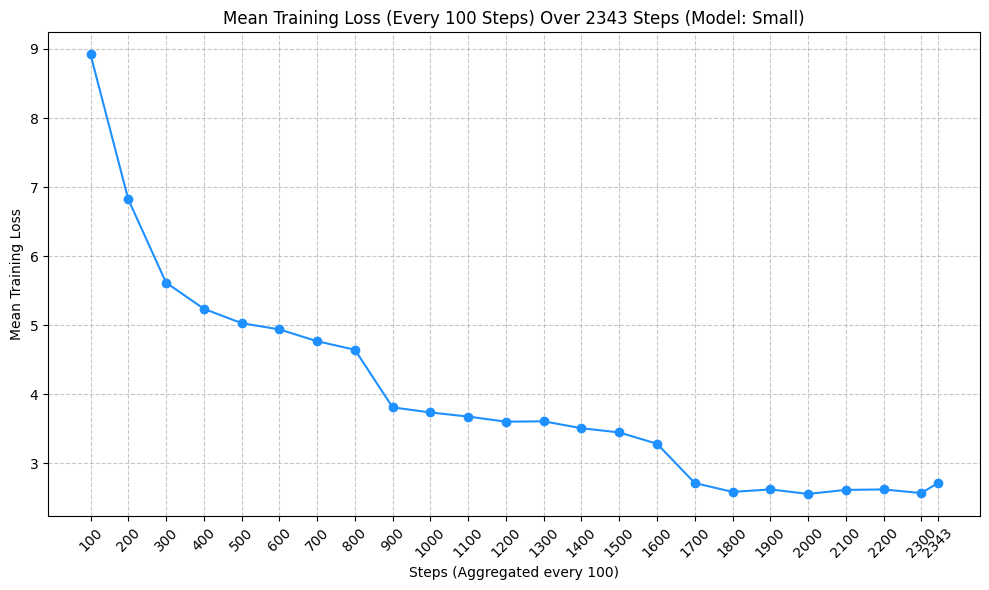

Original number of loss points: 2343
Number of points after averaging every 100 steps: 24
Mean steps plotted: [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2343]
Mean losses plotted: [np.float32(8.92279), np.float32(6.8220763), np.float32(5.615742), np.float32(5.237102), np.float32(5.0290165), np.float32(4.937918), np.float32(4.767325), np.float32(4.643238), np.float32(3.8085809), np.float32(3.735101), np.float32(3.6756895), np.float32(3.6014445), np.float32(3.6065772), np.float32(3.5067513), np.float32(3.4455137), np.float32(3.2817936), np.float32(2.7126484), np.float32(2.5842178), np.float32(2.620362), np.float32(2.5551562), np.float32(2.6131845), np.float32(2.6200814), np.float32(2.5670884), np.float32(2.711178)]
Remember: This is training loss. A separate validation loss plot would be ideal
to monitor for overfitting and for hyperparameter tuning (e.g., early stopping).


In [155]:
# --- Visualizing Learning: Plotting Training Loss ---
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np

steps_ran = len(train_losses)
# Calculate the mean of every 100 steps
chunk_size = 100
#The number of chunks we can make
num_chunks = steps_ran // chunk_size

mean_losses = []
#The x-values for our plot
mean_steps = []

for i in range(num_chunks):
    start_index = i * chunk_size
    end_index = start_index + chunk_size
    chunk = train_losses[start_index:end_index]
    mean_losses.append(np.mean(chunk))
    mean_steps.append(start_index + chunk_size) # Plotting at the end of the chunk

# Handle the remaining steps if steps_ran is not a perfect multiple of chunk_size
if steps_ran % chunk_size != 0:
    remaining_chunk = train_losses[num_chunks * chunk_size:]
    if len(remaining_chunk) > 0: #Make sure there actually are remaining steps
        mean_losses.append(np.mean(remaining_chunk))
        mean_steps.append(steps_ran)


plt.figure(figsize=(10, 6))
plt.plot(mean_steps, mean_losses, marker='o', linestyle='-', color='dodgerblue')
plt.title(f'Mean Training Loss (Every {chunk_size} Steps) Over {steps_ran} Steps (Model: {model_size_str.capitalize()})')
plt.xlabel(f'Steps (Aggregated every {chunk_size})')
plt.ylabel('Mean Training Loss')
# Adjust x-ticks to match the mean_steps
plt.xticks(mean_steps, rotation=45) # Rotate for better readability if many ticks
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

print(f"Original number of loss points: {len(train_losses)}")
print(f"Number of points after averaging every {chunk_size} steps: {len(mean_losses)}")
print("Mean steps plotted:", mean_steps) # You can uncomment these to see the values
print("Mean losses plotted:", mean_losses)

print("Remember: This is training loss. A separate validation loss plot would be ideal")
print("to monitor for overfitting and for hyperparameter tuning (e.g., early stopping).")

In [159]:
# Let's zip and download our weights
!cd /tmp/checkpoints/ && ls -al && zip -r transformer_eng_spa_small.zip transformer_eng_spa_small/

from google.colab import files
files.download("/tmp/checkpoints/transformer_eng_spa_small.zip")

total 12
drwxr-xr-x 3 root root 4096 May  6 16:33 .
drwxrwxrwt 1 root root 4096 May  6 16:34 ..
drwxr-xr-x 3 root root 4096 May  6 16:35 transformer_eng_spa_small
  adding: transformer_eng_spa_small/ (stored 0%)
  adding: transformer_eng_spa_small/2220/ (stored 0%)
  adding: transformer_eng_spa_small/2220/_CHECKPOINT_METADATA (deflated 47%)
  adding: transformer_eng_spa_small/2220/model/ (stored 0%)
  adding: transformer_eng_spa_small/2220/model/_METADATA (deflated 97%)
  adding: transformer_eng_spa_small/2220/model/d/ (stored 0%)
  adding: transformer_eng_spa_small/2220/model/d/29e064c4e921595f0daeb708157edc25 (stored 0%)
  adding: transformer_eng_spa_small/2220/model/array_metadatas/ (stored 0%)
  adding: transformer_eng_spa_small/2220/model/array_metadatas/process_0 (deflated 95%)
  adding: transformer_eng_spa_small/2220/model/_sharding (deflated 94%)
  adding: transformer_eng_spa_small/2220/model/ocdbt.process_0/ (stored 0%)
  adding: transformer_eng_spa_small/2220/model/ocdbt.proc

In [160]:
from google.colab import files
files.download("/tmp/checkpoints/transformer_eng_spa_small.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### The Moment of Truth: BLEU Score Bonanza with Metrax!

Alright, our model has been trained (hopefully without too much drama), and we've even peeked at its training loss curve. Lower loss is nice, but for a translation task, we need a more direct measure of translation quality.

Enter the **BLEU (Bilingual Evaluation Understudy) score**.

* **What it is:** BLEU is an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another. Quality is considered to be the correspondence between a machine's output and that of a human: "the closer a machine translation is to a professional human translation, the better it is."
* **How it works (in a nutshell):** It measures the n-gram precision (how many unigrams, bigrams, trigrams, etc., in the machine translation match those in the reference human translations), tempered by a brevity penalty (to penalize translations that are too short).
* **Scale:** BLEU scores are typically between 0 and 1 (or 0 and 100). Higher is better.
* **Limitations:** BLEU is not perfect. It mainly focuses on word overlap and doesn't capture semantic meaning, fluency, or grammatical correctness perfectly. A human might rate a translation with a lower BLEU score as better than one with a higher score. However, it's a widely used, language-independent, and quick-to-calculate metric, making it useful for tracking progress and comparing models.

**Our Tool: `metrax`**
Google's `metrax` library provides implementations of various evaluation metrics, including BLEU. We installed it earlier. We'll use it to compare our model's generated Spanish translations against the ground truth Spanish sentences from a test portion of our dataset.

To do this, we'll need to:
1.  Set aside a small test set from our `spa-eng` data that the model hasn't seen during training.
2.  Generate translations for the English sentences in this test set using our trained `Transformer` model (in `is_training=False` mode, and potentially using a generation strategy like beam search, though we'll start with simple greedy decoding).
3.  Compare these generated translations with the reference Spanish translations using `metrax.bleu`.

Let's get our model ready for this crucial exam!